# Tutorial

The main purpose of libdyni is to ease the creation of mini-batches (data + targets) to be fed to some machine learning algorithm.

## Data structures

### Segment

Segments are the base elements of the mini-batches. From a machine learning perspective, 1 segment = 1 example.

Audio files are split into overlapping fixed-length segments, stored in *segment containers*.

Every segment, along with its parent segment container, contains all the data needed to feed a mini-batch (label, features, whether it contains activity or not).

### Segment container

A segment container is related to an audio file (1 segment container per audio file). It contains the path of the audio file as well as a list of segments.

### Feature container

A feature container contains all the short-term features (e.g. spectral flatness, mel-spectra...), as well as their parameters, computed from a given audio file. When saved on disk, features are not directly stored in segments because that would imply a lot of duplicated data (since segments most often overlap). Instead, they are saved as feature container dumps.

### Dataset split

A dataset split describes how a dataset is split into train/validation/test sets. It is basically a dictionary with a key for each set and a list of files as its value.


## Examples

[Create segment containers and set labels](#Create-segment-containers-and-set-labels)

[Plot a frame from an audio file](#Plot-a-frame-from-an-audio-file)

### Create segment containers and set labels

In [1]:
from libdyni.utils.segment_container import create_segment_containers_from_audio_files
from libdyni.parsers.label_parsers import CSVLabelParser


# create a segment container generator
sc_gen = create_segment_containers_from_audio_files("tests/data")

# instanciate the label parser (labels.csv contains the pairs file/label)
parser = CSVLabelParser("tests/data/labels.csv")

# now for every segment container, set and show the label
for sc in sc_gen:
    sc.labels = parser.get_label(sc.audio_path)
    print("Label for file {0}: {1}".format(sc.audio_path, sc.labels))

Label for file ID0132.wav: {'bird_c'}
Label for file ID1238.wav: {'bird_d'}


### Plot a frame from an audio file

Populating the interactive namespace from numpy and matplotlib


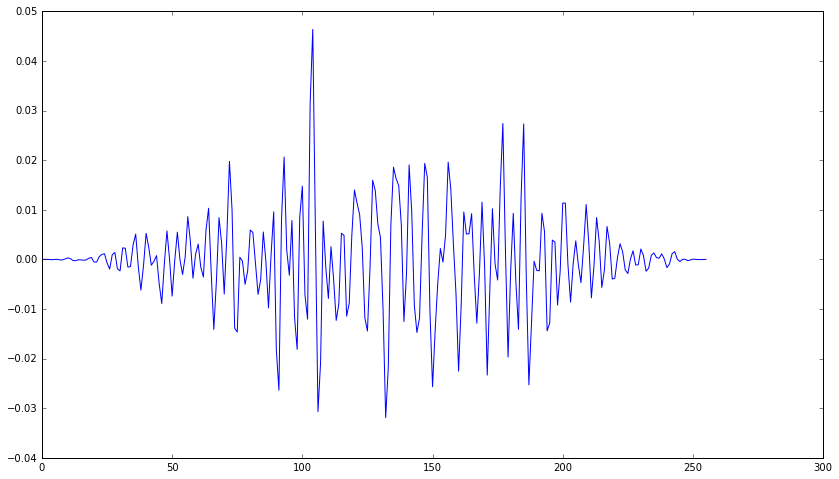

In [2]:
import os
import matplotlib.pyplot as plt

from libdyni.generators.audio_frame_gen import AudioFrameGen

# some matplotlib config
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (14, 8)

# data
audio_root = "tests/data"
audio_filename = "ID0132.wav"

# create and execute an audio frame generator
win_size = 256
hop_size = 128
af_gen = AudioFrameGen(win_size, hop_size) # default window is hanning
af_gen_e = af_gen.execute(os.path.join(audio_root, "ID0132.wav"))

# get third frame, and plot
next(af_gen_e) # 1st frame
next(af_gen_e) # 2nd frame
frame = next(af_gen_e) # 3rd frame
plt.plot(frame)

### Generate mini-batches with mel-spectra

In [3]:
from libdyni.generators.segment_container_gen import SegmentContainerGenerator
from libdyni.generators.audio_frame_gen import AudioFrameGen
from libdyni.features.extractors.energy import EnergyExtractor
from libdyni.features.extractors.spectral_flatness import SpectralFlatnessExtractor
from libdyni.features.extractors.mel_spectrum import MelSpectrumExtractor
from libdyni.features.frame_feature_processor import FrameFeatureProcessor
from libdyni.features.segment_feature_processor import SegmentFeatureProcessor
from libdyni.features.extractors.frame_feature_chunk import FrameFeatureChunkExtractor
from libdyni.features.extractors.activity_detection import ActivityDetection
from libdyni.parsers import label_parsers
from libdyni.utils.batch import gen_minibatches


#################
# Configuration #
#################

# audio and short-term frames config
audio_root = "tests/data"
sample_rate = 22050
win_size = 256
hop_size = 128

# mel spectra config
n_mels = 64
min_freq = 0
max_freq = sample_rate / 2

# segments config
seg_duration = 0.2
seg_overlap = 0.5

# activity detection config
energy_threshold = 0.2
spectral_flatness_threshold = 0.3

# mini-batches config
batch_size = 10
n_features = n_mels
n_time_bins = int(seg_duration * sample_rate / hop_size)

# sorted list of labels for the audio files in audio_root
# the file/label pairs are defined in label.csv
labels = sorted(["bird_c", "bird_d"])

##############
# Processing #
##############

# create a parser to get the labels from the labels.csv file
parser = label_parsers.CSVLabelParser("tests/data/labels.csv")

# create needed short-term (aka frame-based) feature extractors
en_ext = EnergyExtractor() # needed for the activity detection
sf_ext = SpectralFlatnessExtractor() # needed for the activity detection
mel_ext = MelSpectrumExtractor(    
    sample_rate=sample_rate,
    fft_size=win_size,
    n_mels=n_mels,
    min_freq=min_freq,
    max_freq=max_freq)

# create an audio frame generator
af_gen = AudioFrameGen(win_size=win_size, hop_size=hop_size)

# create a frame feature processor, in charge of computing all short-term features
ff_pro = FrameFeatureProcessor(
    af_gen,
    [en_ext, sf_ext, mel_ext])

# create needed segment-based feature extractors
ffc_ext = FrameFeatureChunkExtractor(mel_ext.name)
act_det = ActivityDetection(
        energy_threshold=energy_threshold,
        spectral_flatness_threshold=spectral_flatness_threshold)

# create a segment feature processor, in charge of computing all segment-based features
# (here only chunks of mel spectra sequences)
sf_pro = SegmentFeatureProcessor(
        [act_det, ffc_ext],
        ff_pro=ff_pro,
        audio_root=audio_root)

# create and start the segment container generator that will use all the objects above to generate
# for every audio files a segment container containing the list of segments with the labels,
# the mel spectra and an "activity detected" boolean attribute
sc_gen = SegmentContainerGenerator(
       audio_root,
       parser,
       sf_pro,
       seg_duration=seg_duration,
       seg_overlap=seg_overlap)
sc_gen.start()

# generate mini-batches
mb_gen = gen_minibatches(
    sc_gen,
    labels,
    batch_size,
    n_features,
    n_time_bins,
    mel_ext.name,
    active_segment_only=True)

# get the first mini-batch
data, target = next(mb_gen)

/home/jul/Development/miniconda/envs/libdyni/lib/python3.5/site-packages/librosa/core/audio.py:37: UserWarning: Could not import scikits.samplerate. Falling back to scipy.signal
  warnings.warn('Could not import scikits.samplerate. '


In [4]:
# Show the label indices of the first mini-batch
print("Label indices:\n{}".format(target))

Label indices:
[0 0 0 0 0 0 0 0 0 0]


In [5]:
# and the data
print("Mel spectra (truncated):\n{}".format(data))

Mel spectra (truncated):
[[[[-77.88076782 -66.65984344 -85.78934479 ..., -61.77670288 -69.87345886
    -66.31863403]
   [-74.55519867 -63.33428192 -82.46378326 ..., -58.45114136 -66.54789734
    -62.9930687 ]
   [-66.03651428 -51.91387939 -58.83434677 ..., -49.6537323  -54.32802963
    -62.22982788]
   ..., 
   [-52.81373978 -56.42927933 -57.59656143 ..., -45.98276901 -46.00500107
    -45.56991959]
   [-54.35548019 -55.33501053 -53.44735718 ..., -52.01996231 -51.14955139
    -50.94314575]
   [-61.97282028 -56.9071846  -58.29795074 ..., -59.93020248 -59.93471146
    -54.18180847]]]


 [[[-75.68052673 -72.4744339  -95.34684753 ..., -92.85736847 -68.09340668
    -61.43295288]
   [-72.35495758 -69.14886475 -92.02128601 ..., -89.53180695 -64.76783752
    -58.10738754]
   [-59.55133438 -55.01808548 -62.05028534 ..., -55.01891327 -55.13725662
    -52.58815765]
   ..., 
   [-53.12981415 -50.01371765 -51.11210632 ..., -54.59425354 -51.61140442
    -54.05944443]
   [-54.07550812 -53.38811111 -53